In [30]:
import math
import numpy as np

import pandas as pd
import scipy.io as io
import os 
import csv

from tqdm import tqdm 

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split

from torch.utils.tensorboard import SummaryWriter

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

In [31]:
def same_seed(seed):
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

def train_valid_split(data_set, valid_ratio, seed):
    valid_dataset_size = int(len(data_set) * valid_ratio)
    train_dataset_size = len(data_set) - valid_dataset_size
    train_set, valid_dataset = random_split(data_set, [train_dataset_size, valid_dataset_size], generator=torch.Generator().manual_seed(seed))
    return np.array(train_set), np.array(valid_dataset)

def predict(test_loader, model, device):
    model.eval()
    preds = torch.Tensor([])
    for x in tqdm(test_loader):
        x = x.float().to(device)
        with torch.no_grad():
            pred = model(x)
            preds = torch.concat((preds, pred.detach().to('cpu')))
    # prds = torch.cat(preds, dim=0).numpy()
    return preds

def sparseLoss(model, signal):
    model_children = list(model.children())
    loss = 0
    value = signal
    for child in model_children:
        value = model(signal)
        loss += torch.mean(torch.abs(value))
    return loss

In [32]:
class RespData(Dataset):

    def __init__(self, x):
        self.x = x

    def __getitem__(self, idx):
        return self.x[idx]
    
    def __len__(self):
        return len(self.x)

In [33]:
class FCAE(nn.Module):

    def __init__(self, inputDim):
        super(FCAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(inputDim, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16)
        )
        self.decoder = nn.Sequential(
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, inputDim)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [34]:
def trainer(train_loader, valid_loader, model, config, device):
    criterion = nn.MSELoss(reduction='mean')
    optimizer = torch.optim.Adam(model.parameters(), lr=config['learning_rate'])    
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=config['step_size'], gamma=config['gamma'])

    writer = SummaryWriter()

    if not os.path.isdir('./FCAE/'):
        os.mkdir('./FCAE')
    
    n_epochs, best_loss, step, early_stop_count = config['n_epochs'], np.inf, 0, 0

    for epoch in range(n_epochs):
        model.train()
        loss_record = []

        train_pbar = tqdm(train_loader, position=0, leave=True)

        for x in train_pbar:
            optimizer.zero_grad()
            x = x.float().to(device)
            pred = model(x)
            loss = criterion(pred, x)
            if config['useL1']:
                loss += sparseLoss(model, x)

            loss.backward()
            optimizer.step()
            scheduler.step()

            step += 1
            loss_record.append(loss)

            train_pbar.set_description(f'Epoch [{epoch}/{n_epochs}]')
            train_pbar.set_postfix({'loss': loss.detach().item()})
        
        mean_train_loss = sum(loss_record) / len(loss_record)
        writer.add_scalar('FCAE_Loss/train', mean_train_loss, step)

        model.eval()
        loss_record = []
        for x in valid_loader:
            x = x.float().to(device)
            with torch.no_grad():
                pred = model(x)
                loss = criterion(pred, x)
            loss_record.append(loss.item())
        
        mean_valid_loss = sum(loss_record) / len(loss_record)
        print(f'Epoch [{epoch+1}/{n_epochs}]: Train loss: {mean_train_loss:.4f}, Valid loss: {mean_valid_loss:.4f}')
        writer.add_scalar('FCAE_Loss/valid', mean_valid_loss, step)

        if mean_valid_loss < best_loss:
            best_loss = mean_valid_loss
            torch.save(model.state_dict(), config['best_model'])
            print('Saving model with loss {:.3f}...'.format(best_loss))
            early_stop_count = 0
        else:
            early_stop_count += 1
        
        if early_stop_count >= config['early_stop']:
            print('\nModel is not imporving, so we halt the traing session.')
            return 
        
        torch.save(model.state_dict(), config['last_model'])
    writer.flush()
    writer.close()


In [35]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

config = {
    'learning_rate': 1e-4,
    'seed': 914122,
    'valid_ratio': 0.1,
    'n_epochs': 10000,
    'batch_size': 16,
    'early_stop': 400,
    'best_model': './FCAE/best_0810.ckpt',
    'last_model': './FCAE/last_0810.ckpt',
    'step_size': 1000,
    'gamma': 0.9999,
    'useL1': True
}

In [36]:
def split_data(data, stride=6):
    repeatNum, frameNum, cellNum = data.shape
    result = np.empty([0, cellNum*stride])
    for i in range(repeatNum):
        for j in range(frameNum - stride):
            result = np.concatenate((result, data[i, j:j+stride, :].reshape((1, cellNum*stride))))
    return result

In [37]:
same_seed(config['seed'])

data = np.load('./myData/PDG_data_split_FCAE.npy')

sequenceNum, cellNum = data.shape
data = data.reshape((sequenceNum, cellNum))

train_data, valid_data = train_valid_split(data, config['valid_ratio'], config['seed'])
train_dataset, valid_dataset = RespData(train_data), RespData(valid_data)
print(f'train dataset size: {train_data.shape}')
print(f'valid dataset size: {valid_data.shape}')


train dataset size: (5141, 2226)
valid dataset size: (571, 2226)


In [38]:
train_loader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True, pin_memory=True)
valid_loader = DataLoader(valid_dataset, batch_size=config['batch_size'], pin_memory=True)

In [ ]:
Day1FCAE = FCAE(cellNum).to(device)
trainer(train_loader, valid_loader, Day1FCAE, config, device)

In [ ]:
%reload_ext tensorboard
%tensorboard --logdir=./runs/

In [10]:
# MAPE 平均绝对百分比误差
# formula np.sum((y-yhat) ** 2 / y**2, axis=1) / cellNum
# 更换方法 np.sum(abs(y-yhat) / y, axis=1) / cellNum
def getMAPE(y, yHat):
    num = y.shape[1]
    return np.sum((y-yHat)**2 / y**2, axis=1) / num

#### 比较使用Day1数据训练的AE在数据MOV和PDG中的表现（均使用Day1数据测试，Mouse1）

In [40]:
def getMSE(y, yHat):
    num = y.shape[1]
    return np.sum((y-yHat)**2, axis=1) / num

In [41]:
MOV_data = np.load('./myData/MOV_data_split_FCAE.npy')
PDG_data = np.load('./myData/PDG_data_split_FCAE.npy')

cell_frame = MOV_data.shape[1]

In [42]:
device = 'cuda' if torch.cuda.is_available() else 'cpu' 
Day1FCAE = FCAE(cell_frame)
Day1FCAE.load_state_dict(torch.load('./FCAE/last_0811.ckpt'))
Day1FCAE = Day1FCAE.to(device)

In [43]:
MOV_dataset, PDG_dataset = RespData(MOV_data), RespData(PDG_data)

MOV_dataloader, PDG_dataloader = DataLoader(MOV_dataset, batch_size=16), DataLoader(PDG_dataset, batch_size=16)

In [44]:
MOV_pred = predict(MOV_dataloader, Day1FCAE, device)
print(torch.Tensor(MOV_pred).shape)

PDG_pred = predict(PDG_dataloader, Day1FCAE, device)
print(PDG_pred.shape)

100%|██████████| 645/645 [00:07<00:00, 89.07it/s] 


torch.Size([10320, 2226])


100%|██████████| 357/357 [00:02<00:00, 138.97it/s]

torch.Size([5712, 2226])


In [45]:
def draw_hitogram(df, column='MAPE'):
    sns.set_theme(style="ticks")

    f, ax = plt.subplots(figsize=(7, 5))
    sns.despine(f)

    sns.histplot(
        df,
        x=column,
        multiple="stack",
        palette="light:m_r",
        edgecolor=".3",
        linewidth=.5,
        log_scale=False,
    )
    ax.xaxis.set_major_formatter(mpl.ticker.ScalarFormatter())
    # ax.set_xticks([500, 1000, 2000, 5000, 10000])

In [46]:
# MOV_MAPE = getMAPE(MOV_data, MOV_pred.numpy())
# PDG_MAPE = getMAPE(PDG_data, PDG_pred.numpy())
# # print(test_MAPE.shape)
# MOV_df = pd.DataFrame(MOV_MAPE, columns=['MAPE'])
# PDG_df = pd.DataFrame(PDG_MAPE, columns=['MAPE'])

MOV_MSE = getMSE(MOV_data, MOV_pred.numpy())
PDG_MSE = getMSE(PDG_data, PDG_pred.numpy())
# print(test_MAPE.shape)
MOV_df = pd.DataFrame(MOV_MSE, columns=['MSE'])
PDG_df = pd.DataFrame(PDG_MSE, columns=['MSE'])

Text(0.5, 1.0, 'Day1 FCAE MSE in MOV')

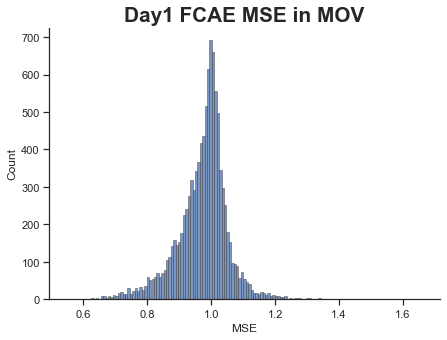

In [47]:
draw_hitogram(MOV_df, column='MSE')
plt.title('Day1 FCAE MSE in MOV', fontsize='xx-large',fontweight='heavy')
# plt.savefig('./FCAE_MOV.jpg', dpi=400)


Text(0.5, 1.0, 'Day1 FCAE MSE in PDG')

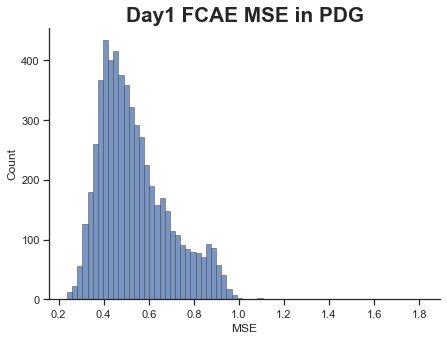

In [48]:
draw_hitogram(PDG_df, column='MSE')
plt.title('Day1 FCAE MSE in PDG', fontsize='xx-large',fontweight='heavy')
# plt.savefig('./FCAE_PDG.jpg', dpi=400)

#### 比较白噪声

In [49]:
whiteNoise = np.random.normal(0, 1, (10000, cell_frame))
whiteNoise_dataset = RespData(whiteNoise)
whiteNoise_dataloader = DataLoader(whiteNoise_dataset, batch_size=16)

In [50]:
whiteNoise_prediction = predict(whiteNoise_dataloader, Day1FCAE, device)

100%|██████████| 625/625 [00:07<00:00, 80.24it/s] 


In [51]:
whiteNoise_MAPE = getMSE(whiteNoise, whiteNoise_prediction.numpy())
whiteNoise_df = pd.DataFrame(whiteNoise_MAPE, columns=['MSE'])

Text(0.5, 1.0, 'Day1 FCAE MSE in White Noise')

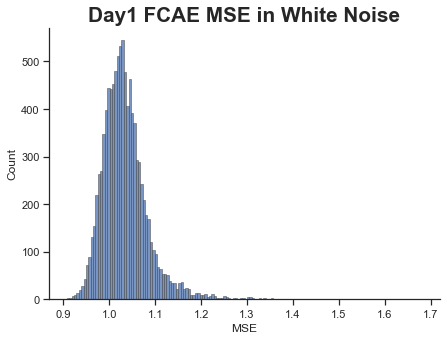

In [52]:
draw_hitogram(whiteNoise_df, column='MSE')
plt.title('Day1 FCAE MSE in White Noise', fontsize='xx-large',fontweight='heavy')
# plt.savefig('./FCAE_WhiteNoise.jpg')

#### 不同时间预测误差分布

In [53]:
def getPDGDataset(sessionData):
    repeatNum, frameNum, cellNum = sessionData.shape
    sessionData = sessionData.reshape((repeatNum*frameNum, cellNum))
    sessionData = (sessionData - np.mean(sessionData, axis=1, keepdims=True)) / np.std(sessionData, axis=1, keepdims=True)
    sessionData = sessionData.reshape((repeatNum, frameNum, cellNum))

    # split the data, stride 6, step 1
    sessionData = split_data(sessionData)

    return sessionData

In [54]:
Respdata = io.loadmat('./Main experiments/Mouse 1/RespData.mat')
Respdata = Respdata['RespData'][0][0][0][0][0][0]

In [55]:
repeatNum, frameNum, cellNum, sessionNum = Respdata.shape
# PDG_Data = [getPDGDataset(Respdata[:, :, :, i]) for i in range(sessionNum)]
PDG_Data = [np.load(f'./myData/Mouse1/Session{i}_PDG_split.npy') for i in range(5)]


In [56]:
PDG_Dataset = [RespData(d) for d in PDG_Data]
PDG_Dataloader = [DataLoader(dataset, batch_size=16) for dataset in PDG_Dataset]

In [57]:
PDG_Predictions = [predict(dataloader, Day1FCAE, device) for dataloader in PDG_Dataloader]

100%|██████████| 357/357 [00:02<00:00, 148.21it/s]


In [58]:
PDG_MSE = [getMSE(d, pred.numpy()) for d, pred in zip(PDG_Data, PDG_Predictions)]

In [59]:
PDG_df = [pd.DataFrame(mse, columns=[f'MSE Day {i*7}']) for i, mse in enumerate(PDG_MSE)]

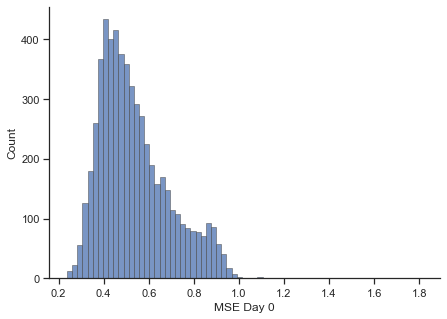

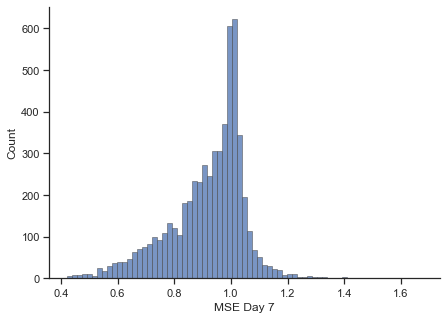

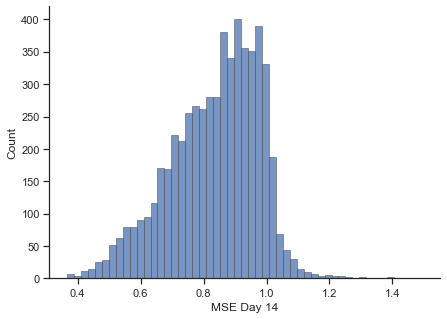

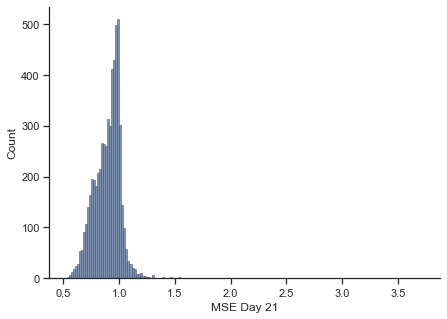

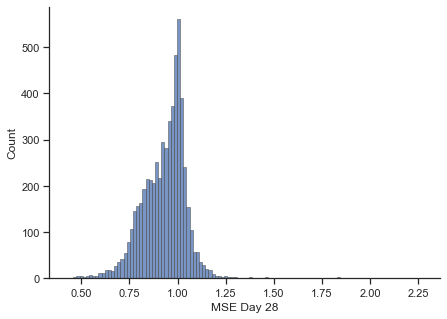

In [60]:
for i in range(5):
    draw_hitogram(PDG_df[i][PDG_df[i][f'MSE Day {i*7}'] <= 5], f'MSE Day {i*7}')
    # plt.savefig(f'FCAE{i}.jpg', dpi=400)

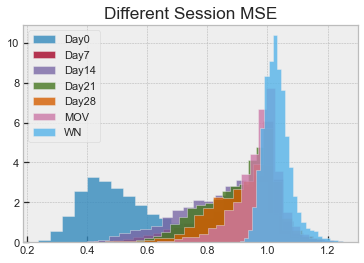

In [65]:
# Fixing random state for reproducibility
np.random.seed(19680801)

plt.style.use('bmh')
fig, ax = plt.subplots()
# print(PDG_df)
ax.hist(PDG_df[0][PDG_df[0]['MSE Day 0'] < 1.25], histtype="stepfilled", bins=25, alpha=0.8, density=True, label='Day0')
ax.hist(PDG_df[1][PDG_df[1]['MSE Day 7'] < 1.25], histtype="stepfilled", bins=25, alpha=0.8, density=True, label='Day7')
ax.hist(PDG_df[2][PDG_df[2]['MSE Day 14'] < 1.25], histtype="stepfilled", bins=25, alpha=0.8, density=True, label='Day14')
ax.hist(PDG_df[3][PDG_df[3]['MSE Day 21'] < 1.25], histtype="stepfilled", bins=25, alpha=0.8, density=True, label='Day21')
ax.hist(PDG_df[4][PDG_df[4]['MSE Day 28'] < 1.25], histtype="stepfilled", bins=25, alpha=0.8, density=True, label='Day28')
ax.hist(MOV_df[MOV_df['MSE'] < 1.25], histtype="stepfilled", bins=25, alpha=0.8, density=True, label='MOV')
ax.hist(whiteNoise_df[whiteNoise_df['MSE'] < 1.25], histtype="stepfilled", bins=25, alpha=0.8, density=True, label='WN')
ax.set_title("Different Session MSE")

ax.legend(loc='upper left')

plt.show()
# plt.savefig('./LSTMAE_DAY.jpg', dpi=400)

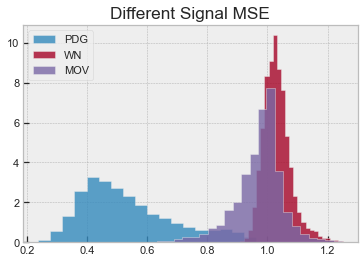

In [70]:
# Fixing random state for reproducibility
np.random.seed(19680801)

plt.style.use('bmh')

fig, ax = plt.subplots()
# print(PDG_df)
ax.hist(PDG_df[0][PDG_df[0]['MSE Day 0'] < 1.25], histtype="stepfilled", bins=25, alpha=0.8, density=True, label='PDG')
ax.hist(whiteNoise_df[whiteNoise_df['MSE'] < 1.25], histtype="stepfilled", bins=25, alpha=0.8, density=True, label='WN')
ax.hist(MOV_df[MOV_df['MSE'] < 1.25], histtype="stepfilled", bins=25, alpha=0.8, density=True, label='MOV')
ax.set_title("Different Signal MSE")

ax.legend(loc='upper left')

plt.show()

# plt.savefig('./LSTMAE_SIGNAL.jpg', dpi=400)

#### 测试多只小鼠

In [24]:
mouseNum = 3
MOVPath = './myData/Day0_MOV/MOV_mouse{index}_FCAE.npy'
PDGPath = './myData/Day{day}_PDG/PDG_mouse{index}_FCAE.npy'
modelPath = './FCAE/best_0813_mouse{index}.ckpt'
filePath = './Main experiments/Mouse {index}/RespData.mat'


100%|██████████| 645/645 [00:07<00:00, 83.29it/s] 


torch.Size([10320, 2226])


100%|██████████| 357/357 [00:02<00:00, 129.86it/s]


torch.Size([5712, 2226])


100%|██████████| 625/625 [00:07<00:00, 86.39it/s] 


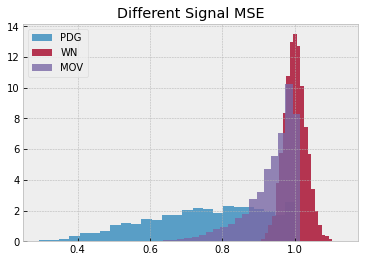

session number is 5


100%|██████████| 357/357 [00:02<00:00, 142.10it/s]


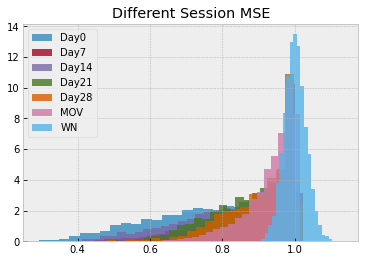

100%|██████████| 645/645 [00:11<00:00, 57.47it/s] 


torch.Size([10320, 3270])


100%|██████████| 357/357 [00:03<00:00, 100.56it/s]


torch.Size([5712, 3270])


100%|██████████| 625/625 [00:10<00:00, 59.30it/s] 


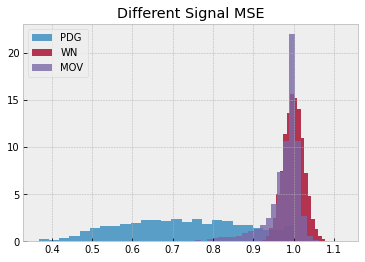

session number is 7


100%|██████████| 357/357 [00:03<00:00, 99.10it/s] 


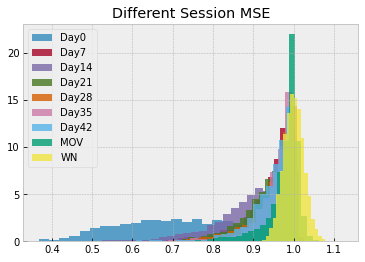

100%|██████████| 645/645 [00:15<00:00, 41.39it/s] 


torch.Size([10320, 4746])


100%|██████████| 357/357 [00:05<00:00, 62.87it/s] 


torch.Size([5712, 4746])


100%|██████████| 625/625 [00:14<00:00, 43.77it/s] 


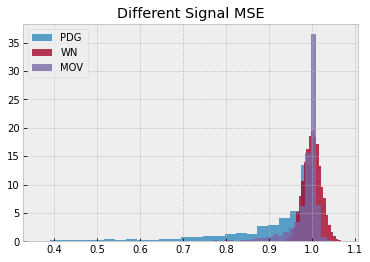

session number is 7


100%|██████████| 357/357 [00:05<00:00, 70.44it/s] 


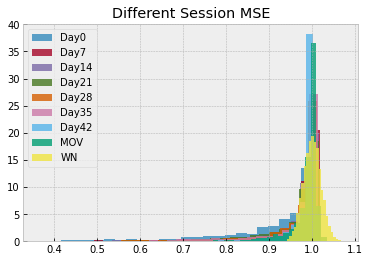

In [29]:
from operator import index


for i in range(mouseNum):
    MOV_data = np.load(MOVPath.format(index=i+1))
    PDG_data = np.load(PDGPath.format(day=0, index=i+1))
    cell_frame = PDG_data.shape[1]

    MOV_dataset, PDG_dataset = RespData(MOV_data), RespData(PDG_data)
    MOV_dataloader, PDG_dataloader = DataLoader(MOV_dataset, batch_size=16), DataLoader(PDG_dataset, batch_size=16)

    device = 'cuda' if torch.cuda.is_available() else 'cpu' 
    Day1FCAE = FCAE(cell_frame)
    Day1FCAE.load_state_dict(torch.load(modelPath.format(index=i+1)))
    Day1FCAE = Day1FCAE.to(device)

    MOV_pred = predict(MOV_dataloader, Day1FCAE, device)
    print(torch.Tensor(MOV_pred).shape)

    PDG_pred = predict(PDG_dataloader, Day1FCAE, device)
    print(PDG_pred.shape)

    MOV_MSE = getMSE(MOV_data, MOV_pred.numpy())
    PDG_MSE = getMSE(PDG_data, PDG_pred.numpy())
    # print(test_MAPE.shape)
    MOV_df = pd.DataFrame(MOV_MSE, columns=['MSE'])
    PDG_df = pd.DataFrame(PDG_MSE, columns=['MSE'])

    whiteNoise = np.random.normal(0, 1, (10000, cell_frame))
    whiteNoise_dataset = RespData(whiteNoise)
    whiteNoise_dataloader = DataLoader(whiteNoise_dataset, batch_size=16)
    whiteNoise_prediction = predict(whiteNoise_dataloader, Day1FCAE, device)

    whiteNoise_MAPE = getMSE(whiteNoise, whiteNoise_prediction.numpy())
    whiteNoise_df = pd.DataFrame(whiteNoise_MAPE, columns=['MSE'])

    
    plt.style.use('bmh')

    fig, ax = plt.subplots()
    # print(PDG_df)
    ax.hist(PDG_df['MSE'], histtype="stepfilled", bins=25, alpha=0.8, density=True, label='PDG')
    ax.hist(whiteNoise_df['MSE'], histtype="stepfilled", bins=25, alpha=0.8, density=True, label='WN')
    ax.hist(MOV_df['MSE'], histtype="stepfilled", bins=25, alpha=0.8, density=True, label='MOV')
    ax.set_title("Different Signal MSE")

    ax.legend(loc='upper left')

    plt.show()

    if i+1 != 2:
        data = io.loadmat(filePath.format(index=i+1))
    else:
         
        data = io.loadmat('./Main experiments/Mouse 2/Window 1/RespData.mat')

    sessionNum = data['RespData'][0][0][0][0][0][0].shape[3]
    print(f'session number is {sessionNum}')

    # PDG_Data = [getPDGDataset(Respdata[:, :, :, i]) for i in range(sessionNum)]
    PDG_Data = [np.load(PDGPath.format(day=d*7, index=i+1)) for d in range(sessionNum)]
    PDG_Dataset = [RespData(d) for d in PDG_Data]
    PDG_Dataloader = [DataLoader(dataset, batch_size=16) for dataset in PDG_Dataset]
    PDG_Predictions = [predict(dataloader, Day1FCAE, device) for dataloader in PDG_Dataloader]
    PDG_MSE = [getMSE(d, pred.numpy()) for d, pred in zip(PDG_Data, PDG_Predictions)]
    PDG_df = [pd.DataFrame(mse, columns=[f'MSE Day {i*7}']) for i, mse in enumerate(PDG_MSE)]

    fig, ax = plt.subplots()
    # print(PDG_df)
    for j in range(sessionNum):
        ax.hist(PDG_df[j][f'MSE Day {j*7}'], histtype="stepfilled", bins=25, alpha=0.8, density=True, label=f'Day{j*7}')
    ax.hist(MOV_df['MSE'], histtype="stepfilled", bins=25, alpha=0.8, density=True, label='MOV')
    ax.hist(whiteNoise_df['MSE'], histtype="stepfilled", bins=25, alpha=0.8, density=True, label='WN')
    ax.set_title("Different Session MSE")

    ax.legend(loc='upper left')

    plt.show()


In [21]:
print(sessionNum)

5
